In [1]:
# 导入核心库
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request # 用于下载数据集
import pandas as pd # 导入 pandas，用于辅助数据处理和绘图

# 导入 sklearn 中需要的模块
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # SVM 的分类器 (C-Support Vector Classification)
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

# 设置 matplotlib 在 notebook 中内嵌显示图像
%matplotlib inline

# (推荐) 解决 matplotlib 中文显示乱码的问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
# --- 1.1 (二分类) 加载乳腺癌数据集 ---

# 数据集URL和本地文件名
data_url_bc = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/breast-cancer_scale"
data_file_bc = "breast-cancer.scale"

# 检查文件是否存在，如果不存在则下载
if not os.path.exists(data_file_bc):
    print("正在下载乳腺癌数据集...")
    urllib.request.urlretrieve(data_url_bc, data_file_bc)
    print("下载完成。")

# 使用 load_svmlight_file 读取数据
X_bc_sparse, y_bc_raw = load_svmlight_file(data_file_bc)

# 将稀疏矩阵转换为密集的 numpy 数组
X_bc = X_bc_sparse.toarray()

# LIBSVM 的标签可能是 2 和 4, 我们将其转换为 0 和 1 (良性/恶性)
# 这是此数据集的常规操作
y_bc = np.where(y_bc_raw == 2, 0, 1)

print(f"数据加载完成。 X的形状: {X_bc.shape}, y的形状: {y_bc.shape}")
print(f"标签类别: {np.unique(y_bc)}")

正在下载乳腺癌数据集...
下载完成。
数据加载完成。 X的形状: (683, 10), y的形状: (683,)
标签类别: [0 1]


In [3]:
# --- 1.2 (二分类) 划分与标准化 ---

# 1. 划分训练集和测试集 (70% / 30%)
# stratify=y_bc 确保训练集和测试集中的 0/1 类别比例与原始数据一致
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc, y_bc, test_size=0.3, random_state=42, stratify=y_bc
)

# 2. 特征标准化
scaler_bc = StandardScaler()
X_train_bc_scaled = scaler_bc.fit_transform(X_train_bc)
X_test_bc_scaled = scaler_bc.transform(X_test_bc)

print("乳腺癌数据集：划分与标准化完成。")
print(f"训练集大小: {X_train_bc_scaled.shape[0]}, 测试集大小: {X_test_bc_scaled.shape[0]}")

乳腺癌数据集：划分与标准化完成。
训练集大小: 478, 测试集大小: 205


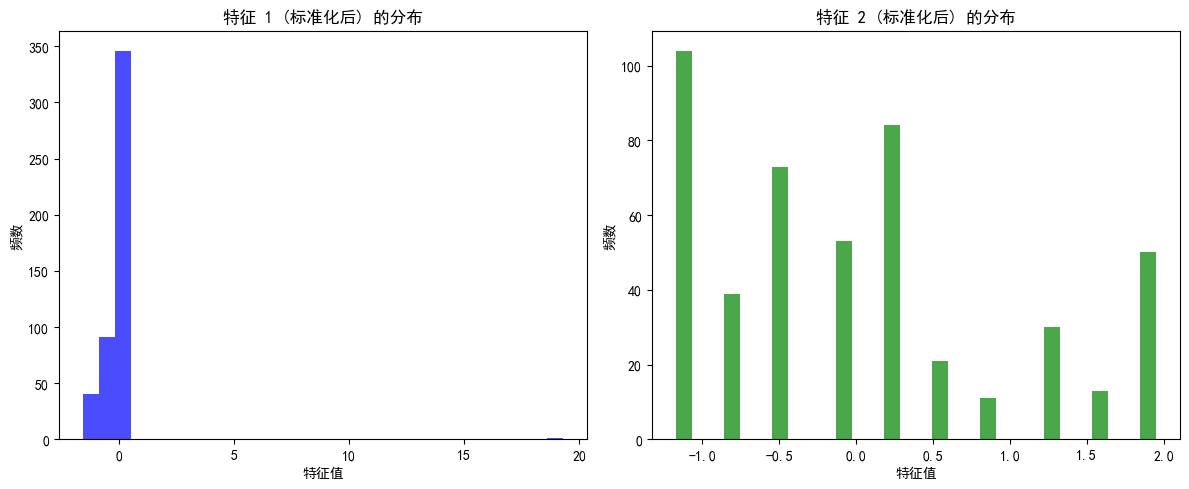

In [4]:
# --- 1.3 (二分类) 特征分布直方图 ---

plt.figure(figsize=(12, 5))

# 绘制标准化后，训练集上第1个特征的分布
plt.subplot(1, 2, 1)
plt.hist(X_train_bc_scaled[:, 0], bins=30, alpha=0.7, color='blue')
plt.title('特征 1 (标准化后) 的分布')
plt.xlabel('特征值')
plt.ylabel('频数')

# 绘制标准化后，训练集上第2个特征的分布
plt.subplot(1, 2, 2)
plt.hist(X_train_bc_scaled[:, 1], bins=30, alpha=0.7, color='green')
plt.title('特征 2 (标准化后) 的分布')
plt.xlabel('特征值')
plt.ylabel('频数')

plt.tight_layout() # 自动调整子图间距
plt.show()

In [5]:
# --- 2.1 (二分类) 模型训练与调优 ---

# 1. 定义模型
# C 是正则化强度的倒数，C 越小，正则化越强
# probability=True 是为了后续能画 ROC 曲线
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
linear_svm = SVC(kernel='linear', probability=True)
rbf_svm = SVC(kernel='rbf', probability=True)

# 2. 定义要搜索的超参数网格
# 我们将测试 5 个不同的 C 值
param_grid_c = {'C': [0.01, 0.1, 1, 10, 100]}

# RBF 核函数除了 C，还有一个 gamma 参数
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

# 3. 封装模型和网格
models_to_tune = [
    ("逻辑回归 (LR)", log_reg, param_grid_c),
    ("线性 SVM", linear_svm, param_grid_c),
    ("RBF 核 SVM", rbf_svm, param_grid_rbf)
]

# 4. 执行网格搜索 (使用 5 折交叉验证 cv=5)
best_models_bc = {} # 用于存储训练好的最佳模型

print("开始在乳腺癌数据集上进行网格搜索调优 (cv=5)...")

for name, model, param_grid in models_to_tune:
    # scoring='accuracy' 表示我们的目标是找到“准确率”最高的参数
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # 在训练集上进行拟合
    grid_search.fit(X_train_bc_scaled, y_train_bc)
    
    # 记录最佳模型
    best_models_bc[name] = grid_search.best_estimator_
    
    print(f"--- {name} ---")
    print(f"最佳验证集准确率 (Average): {grid_search.best_score_:.4f}")
    print(f"最佳参数: {grid_search.best_params_}")
    print("-" * 30)

print("所有模型调优完成。")

开始在乳腺癌数据集上进行网格搜索调优 (cv=5)...
--- 逻辑回归 (LR) ---
最佳验证集准确率 (Average): 0.9770
最佳参数: {'C': 0.01}
------------------------------
--- 线性 SVM ---
最佳验证集准确率 (Average): 0.9728
最佳参数: {'C': 0.01}
------------------------------
--- RBF 核 SVM ---
最佳验证集准确率 (Average): 0.9728
最佳参数: {'C': 10, 'gamma': 0.001}
------------------------------
所有模型调优完成。


In [6]:
# --- 3.1 (二分类) 测试集准确率评估 ---

print("--- 在测试集 (Test Set) 上的最终表现 ---")

for name, model in best_models_bc.items():
    # 用调优好的最佳模型来预测测试集
    y_pred_bc = model.predict(X_test_bc_scaled)
    
    # 计算准确率
    accuracy = accuracy_score(y_test_bc, y_pred_bc)
    
    print(f"{name} 的测试集准确率: {accuracy:.4f}")

--- 在测试集 (Test Set) 上的最终表现 ---
逻辑回归 (LR) 的测试集准确率: 0.9610
线性 SVM 的测试集准确率: 0.9610
RBF 核 SVM 的测试集准确率: 0.9610


<Figure size 1000x800 with 0 Axes>

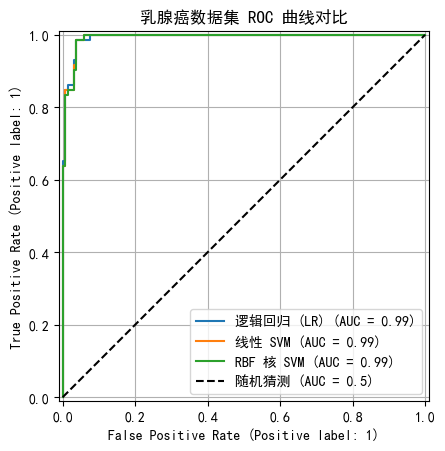

In [7]:
# --- 3.2 (二分类) 绘制 ROC 曲线 ---

plt.figure(figsize=(10, 8))

# 绘制逻辑回归的 ROC
RocCurveDisplay.from_estimator(
    best_models_bc["逻辑回归 (LR)"], 
    X_test_bc_scaled, 
    y_test_bc, 
    name="逻辑回归 (LR)"
)

# 绘制线性 SVM 的 ROC (ax=plt.gca() 表示画在同一张图上)
RocCurveDisplay.from_estimator(
    best_models_bc["线性 SVM"], 
    X_test_bc_scaled, 
    y_test_bc, 
    name="线性 SVM", 
    ax=plt.gca()
)

# 绘制 RBF 核 SVM 的 ROC
RocCurveDisplay.from_estimator(
    best_models_bc["RBF 核 SVM"], 
    X_test_bc_scaled, 
    y_test_bc, 
    name="RBF 核 SVM", 
    ax=plt.gca()
)

# 绘制一条 50% 准确率的“随机猜测”对角线
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测 (AUC = 0.5)')
plt.title('乳腺癌数据集 ROC 曲线对比')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# --- 1.4 (多分类) 加载鸢尾花数据集 ---

# 数据集URL和本地文件名
data_url_iris = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale"
data_file_iris = "iris.scale"

if not os.path.exists(data_file_iris):
    print("正在下载鸢尾花数据集...")
    urllib.request.urlretrieve(data_url_iris, data_file_iris)
    print("下载完成。")

# 加载数据
X_iris_sparse, y_iris = load_svmlight_file(data_file_iris)
X_iris = X_iris_sparse.toarray()

print(f"数据加载完成。 X的形状: {X_iris.shape}, y的形状: {y_iris.shape}")
print(f"标签类别: {np.unique(y_iris)}") # 标签是 1.0, 2.0, 3.0

正在下载鸢尾花数据集...
下载完成。
数据加载完成。 X的形状: (150, 4), y的形状: (150,)
标签类别: [1. 2. 3.]


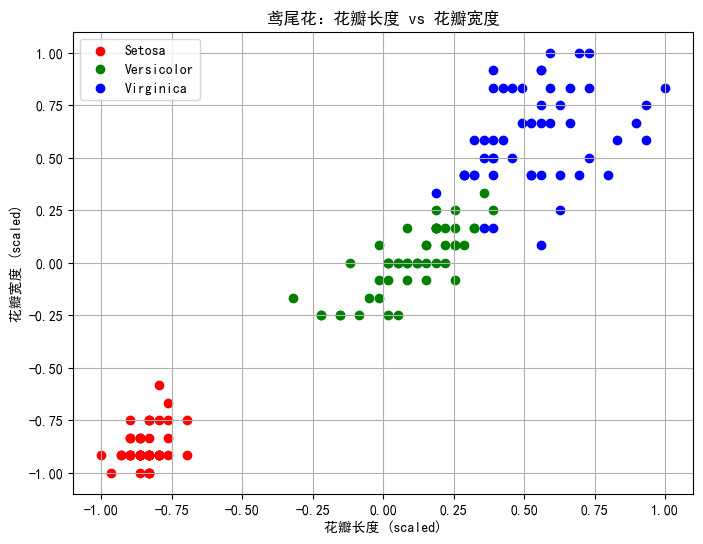

In [9]:
# --- 1.5 (多分类) 特征散点图 ---

# 类别标签 (LIBSVM 中 1, 2, 3 对应这三类)
labels = {1.0: 'Setosa', 2.0: 'Versicolor', 3.0: 'Virginica'}
colors = {1.0: 'red', 2.0: 'green', 3.0: 'blue'}

plt.figure(figsize=(8, 6))

for label_val in np.unique(y_iris):
    # 筛选出当前类别的样本
    subset_indices = np.where(y_iris == label_val)
    subset_X = X_iris[subset_indices]
    
    # 绘制散点图
    plt.scatter(
        subset_X[:, 2], # 花瓣长度 (特征索引 2)
        subset_X[:, 3], # 花瓣宽度 (特征索引 3)
        c=colors[label_val],
        label=labels[label_val]
    )

plt.title('鸢尾花：花瓣长度 vs 花瓣宽度')
plt.xlabel('花瓣长度 (scaled)')
plt.ylabel('花瓣宽度 (scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# --- 1.6 (多分类) 划分与标准化 ---

# 1. 划分训练集和测试集 (70% / 30%)
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

# 2. 特征标准化
scaler_iris = StandardScaler()
X_train_iris_scaled = scaler_iris.fit_transform(X_train_iris)
X_test_iris_scaled = scaler_iris.transform(X_test_iris)

print("鸢尾花数据集：划分与标准化完成。")

鸢尾花数据集：划分与标准化完成。


In [11]:
# --- 2.2 (多分类) 模型训练与调优 ---

# 1. 定义模型
# 逻辑回归需要指定 multi_class='ovr' (One-vs-Rest) 或 'multinomial'
# 'liblinear' 求解器只支持 'ovr'
log_reg_iris = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)

# SVM 默认支持多分类 (使用 'ovr' 策略)
linear_svm_iris = SVC(kernel='linear')
rbf_svm_iris = SVC(kernel='rbf')

# 2. 定义网格 (和之前一样)
param_grid_c = {'C': [0.01, 0.1, 1, 10, 100]}
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto']
}

# 3. 封装
models_to_tune_iris = [
    ("逻辑回归 (LR)", log_reg_iris, param_grid_c),
    ("线性 SVM", linear_svm_iris, param_grid_c),
    ("RBF 核 SVM", rbf_svm_iris, param_grid_rbf)
]

# 4. 执行网格搜索
best_models_iris = {} 
print("开始在鸢尾花数据集上进行网格搜索调优 (cv=5)...")

for name, model, param_grid in models_to_tune_iris:
    grid_search_iris = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_iris.fit(X_train_iris_scaled, y_train_iris)
    
    best_models_iris[name] = grid_search_iris.best_estimator_
    
    print(f"--- {name} ---")
    print(f"最佳验证集准确率 (Average): {grid_search_iris.best_score_:.4f}")
    print(f"最佳参数: {grid_search_iris.best_params_}")
    print("-" * 30)

print("所有模型调优完成。")

开始在鸢尾花数据集上进行网格搜索调优 (cv=5)...


D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


--- 逻辑回归 (LR) ---
最佳验证集准确率 (Average): 0.9714
最佳参数: {'C': 10}
------------------------------
--- 线性 SVM ---
最佳验证集准确率 (Average): 0.9810
最佳参数: {'C': 100}
------------------------------
--- RBF 核 SVM ---
最佳验证集准确率 (Average): 0.9810
最佳参数: {'C': 1, 'gamma': 0.1}
------------------------------
所有模型调优完成。


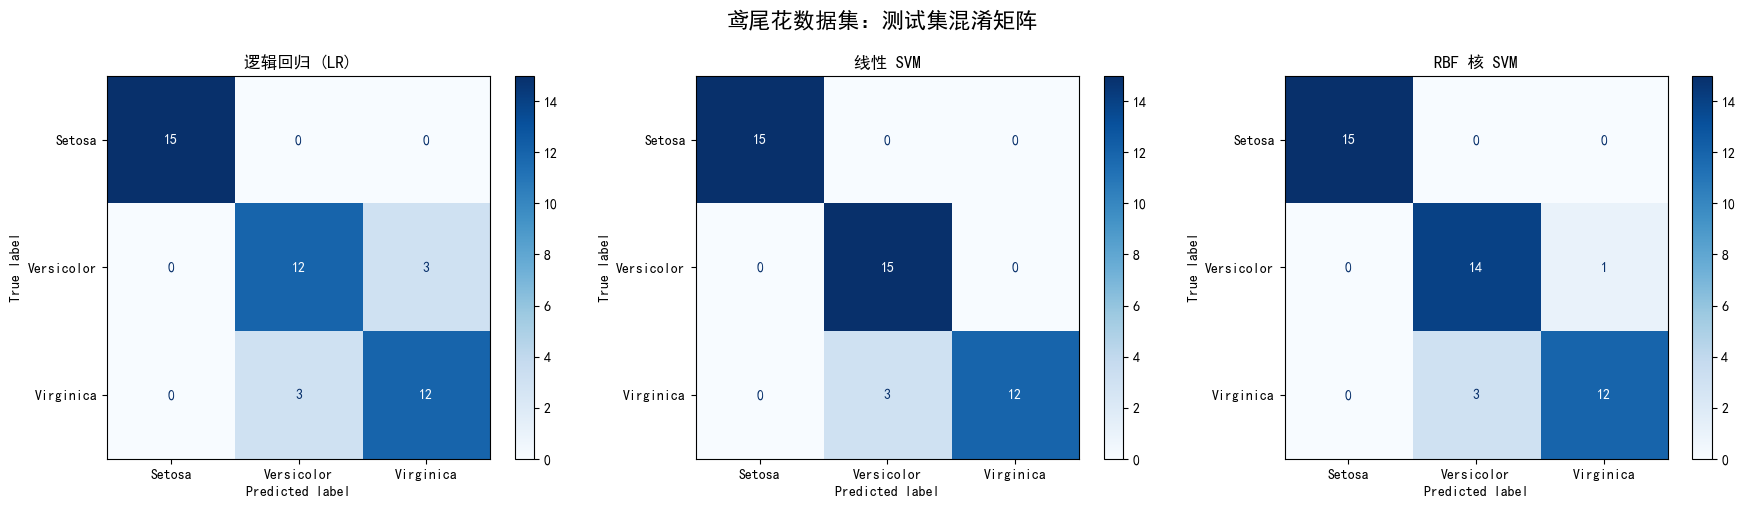

--- 鸢尾花数据集：在测试集 (Test Set) 上的最终准确率 ---
逻辑回归 (LR) 的测试集准确率: 0.8667
线性 SVM 的测试集准确率: 0.9333
RBF 核 SVM 的测试集准确率: 0.9111


In [12]:
# --- 3.3 (多分类) 绘制混淆矩阵 ---

# 获取类别名称
class_names = [labels[val] for val in np.unique(y_iris)]

# 设置 1x3 的子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('鸢尾花数据集：测试集混淆矩阵', fontsize=16)

# 遍历训练好的三个模型
for i, (name, model) in enumerate(best_models_iris.items()):
    ax = axes[i]
    
    # 绘制混淆矩阵
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_iris_scaled,
        y_test_iris,
        ax=ax,
        display_labels=class_names,
        cmap=plt.cm.Blues # 使用蓝色系
    )
    ax.set_title(name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局，为总标题留出空间
plt.show()

# 顺便打印一下测试集准确率
print("--- 鸢尾花数据集：在测试集 (Test Set) 上的最终准确率 ---")
for name, model in best_models_iris.items():
    acc = model.score(X_test_iris_scaled, y_test_iris)
    print(f"{name} 的测试集准确率: {acc:.4f}")